### Load libraries

In [1]:
library(phyloseq)
library(selbal)
library(reshape2)
library(dplyr)
library(zCompositions)
library(ggExtra)
library(ggpubr)
library(rstatix)
library(pracma)
library(pROC)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: NADA

Loading required package: survival


Attaching package: ‘NADA’


The following object is masked from ‘package:stats’:

    cor


Loading required package: truncnorm

Loading required package: ggplot2


Attaching package: ‘rstatix’


The following object is masked from ‘package:MASS’:

    select


The following object is masked from ‘package:stats’:

    filter


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var




In [2]:
dir.create(file.path('../../results/figures'), showWarnings = FALSE)
dir.create(file.path('../../results/figures', 'figure5'), showWarnings = FALSE)
dir.create(file.path('../../results/figures', 'supplementary_figure6'), showWarnings = FALSE)

### Functions

In [3]:
# compute the best number of taxa from cross-validation
best_nvar <- function(selbal_cv_result){
    growth_inds = which(diff(selbal_cv_result$accuracy$data$mean) > 0.001)+1
    if (length(growth_inds) > 0){
        best_ind = growth_inds[which.max(selbal_cv_result$accuracy$data$mean[growth_inds])]
        best_n = selbal_cv_result$accuracy$data$n[best_ind]
        return(best_n)
    } else {
        return(2)
    }
    
}

In [4]:
# compute the balance value
reconstruct_balance <- function(numerator, denominator, otu){
    n = length(numerator)
    m = length(denominator)
    balance_numerator = 1/n*rowSums(log(data.frame(otu[, numerator])))
    balance_denominator = 1/m*rowSums(log(data.frame(otu[, denominator])))
    return(sqrt(n*m/(n+m))*(balance_numerator-balance_denominator))
}

### Load & prepare data

In [5]:
# load phyloseq object
ps_genus <- readRDS('../../data/phyloseq/nohost_genus/phyloseq.rds')
taxa_names(ps_genus) <- tax_table(ps_genus)[, 'Genus']
ps_genus
metadata <- data.frame(sample_data(ps_genus))

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 397 taxa and 199 samples ]
sample_data() Sample Data:       [ 199 samples by 57 sample variables ]
tax_table()   Taxonomy Table:    [ 397 taxa by 7 taxonomic ranks ]

In [7]:
# based on the information of time a participant received the dworming pill the last time
# create a new column, called "prior_deworming", 
# which would contain the information about when the last deworming event tool place:
# notTreated (within a year), > 6 months, < 6 months

# first clean the data in the 'Ifyeswhenwasthelasttimetheygaveyousuchdewormingpill' column
metadata$prior_deworming_month <- metadata[['Ifyeswhenwasthelasttimetheygaveyousuchdewormingpill']]
# remove the word month/Month
metadata$prior_deworming_month <- gsub('Months', '', metadata$prior_deworming_month)
# replace empty values with 0
metadata[metadata$prior_deworming_month == ' ', "prior_deworming_month"] <- '0'
# transform text numbers to integers
metadata$prior_deworming_month <- as.integer(metadata$prior_deworming_month)
# create a prior_deworming based on month integers
metadata$prior_deworming <- metadata$prior_deworming_month
metadata[(metadata$prior_deworming_month == 0), "prior_deworming"] <- 'notTreated'
metadata[(metadata$prior_deworming_month > 0)&(metadata$prior_deworming_month < 7), "prior_deworming"] <- '< 6 months'
metadata[(metadata$prior_deworming_month > 6), "prior_deworming"] <- '> 6 months'

In [8]:
# create a column, called "prior_deworming_followup",
# which would contain the informaton about prior deworming event for samples at baseline
# (from "prior_deworming" column) and follow-up samples will all be marked as 'followup_deworming'
metadata$prior_deworming_followup <- metadata$prior_deworming
metadata[(metadata$collection_timepoint == 'follow-up'), "prior_deworming_followup"] <- 'followup_deworming'

# create a column, called "prior_deworming_followup",
# which to the column "prior_deworming" would add the information if sample is coming from
# the baseline or follow-up time point
metadata$prior_deworming_baseline_followup <- paste(metadata$prior_deworming, metadata$collection_timepoint, sep='_')

# code the same information with numbers:
# 3 - notTreated (within a year), 2 - > 6 months, 1 - < 6 months
vals <- rep(0, length(metadata$prior_deworming_followup))
vals[metadata$prior_deworming_followup == '< 6 months'] <- 1
vals[metadata$prior_deworming_followup == '> 6 months'] <- 2
vals[metadata$prior_deworming_followup == 'notTreated'] <- 3
metadata$prior_deworming_baseline_followup_number <- vals

# add an updated metadata to phyloseq
sample_data(ps_genus) <- metadata

In [9]:
# transform table, to get a new one, which will contain columns with ids of samples 
# from the baseline and follow-up timepoints
# leave only samples from participants that have a follow-up sample
analysis_df <- dcast(metadata,
                     host_subject_id+prior_deworming ~ collection_timepoint, 
                     value.var = "sample_alias")
colnames(analysis_df) <- gsub('follow-up', 'followup', colnames(analysis_df))
analysis_df <- analysis_df[!is.na(analysis_df$followup), ]

row.names(analysis_df) <- analysis_df$baseline
row.names(analysis_df) <- analysis_df$followup
head(analysis_df)

,host_subject_id,prior_deworming,baseline,followup
,<chr>,<chr>,<chr>,<chr>
sample_145,115-KB,notTreated,sample_019,sample_145
sample_146,130-KB,< 6 months,sample_024,sample_146
sample_147,131-KB,> 6 months,sample_025,sample_147
sample_148,137-KB,notTreated,sample_027,sample_148
sample_149,140-KB,notTreated,sample_028,sample_149
sample_150,142-KB,notTreated,sample_030,sample_150


In [10]:
# normalize genus counts
ps_relative <- transform_sample_counts(ps_genus, function(x){x / sum(x)})

# rename taxa
taxa_names(ps_relative) <- gsub('-', '_', taxa_names(ps_relative))

In [11]:
# split a phyloseq object into 2: containing samples at the baseline and follow-up timepoints
ps_baseline <- prune_samples(analysis_df$baseline, ps_relative)
ps_followup <- prune_samples(analysis_df$followup, ps_relative)


In [12]:
# choose only taxa overlapped between baseline and follow-up time points

# select all taxa present in at least one sample of the baseline
taxa_baseline <- colnames(otu_table(ps_baseline))
taxa_baseline <- taxa_baseline[colSums(otu_table(ps_baseline)) > 0]
length(taxa_baseline)

# select all taxa present in at least one sample of the follow-up
taxa_followup <- colnames(otu_table(ps_followup))
taxa_followup <- taxa_followup[colSums(otu_table(ps_followup)) > 0]
length(taxa_followup)

# find an intersection between 2 taxa sets
taxa <- intersect(taxa_baseline, taxa_followup)
length(taxa)

# select only intersected taxa in each phyloseq object
ps_baseline_intersected <- prune_taxa(taxa, ps_baseline)
ps_followup_intersected <- prune_taxa(taxa, ps_followup)

[1] 286

[1] 263

[1] 229

In [13]:
# renormalize counts
ps_baseline_intersected <- transform_sample_counts(ps_baseline_intersected, function(x){x / sum(x)})
ps_followup_intersected <- transform_sample_counts(ps_followup_intersected, function(x){x / sum(x)})

# impute zero abundances with a Bayesian-multiplicative replacement
# for each subset (baseline and follow-up), individually, the function also removes:
#    a) taxa present in less than 50% of samples 
#    b) samples containing more than 50% absent taxa
otu_table(ps_baseline_intersected) <- otu_table(cmultRepl(otu_table(ps_baseline_intersected), 
                                                           z.warning = 0.5), taxa_are_rows=FALSE)
otu_table(ps_followup_intersected) <- otu_table(cmultRepl(otu_table(ps_followup_intersected),
                                                       z.warning = 0.5), taxa_are_rows=FALSE)

# ensure all taxa from baseline subset are still present in the follow-up and vice versa
taxa_baseline <- colnames(otu_table(ps_baseline_intersected))
taxa_followup <- colnames(otu_table(ps_followup_intersected))
taxa <- intersect(taxa_baseline, taxa_followup)
ps_baseline_intersected <- prune_taxa(taxa, ps_baseline_intersected)
ps_followup_intersected <- prune_taxa(taxa, ps_followup_intersected)
# renormalize
ps_baseline_intersected <- transform_sample_counts(ps_baseline_intersected, function(x){x / sum(x)})
ps_followup_intersected <- transform_sample_counts(ps_followup_intersected, function(x){x / sum(x)})

# ensure we still have all pairs of samples baseline/followup
# exclude those sampples, which lost its pair during the imputation
analysis_df_ <- analysis_df
analysis_df_['baseline_in'] = analysis_df_$baseline %in% sample_names(ps_baseline_intersected)
analysis_df_['followup_in'] = analysis_df_$followup %in% sample_names(ps_followup_intersected)
analysis_df_ <- analysis_df_[(analysis_df_$baseline_in)&(analysis_df_$followup_in), ]
ps_baseline_intersected <- prune_samples(analysis_df_$baseline, ps_baseline_intersected)
ps_followup_intersected <- prune_samples(analysis_df_$followup, ps_followup_intersected)



Warning message in cmultRepl(otu_table(ps_baseline_intersected), z.warning = 0.5):
“Column 6 containing more than 50% zeros/unobserved values was deleted (pre-check out using function zPatterns/modify threshold using argument z.warning).
Column 9 containing more than 50% zeros/unobserved values was deleted (pre-check out using function zPatterns/modify threshold using argument z.warning).
Column 13 containing more than 50% zeros/unobserved values was deleted (pre-check out using function zPatterns/modify threshold using argument z.warning).
Column 34 containing more than 50% zeros/unobserved values was deleted (pre-check out using function zPatterns/modify threshold using argument z.warning).
Column 35 containing more than 50% zeros/unobserved values was deleted (pre-check out using function zPatterns/modify threshold using argument z.warning).
Column 39 containing more than 50% zeros/unobserved values was deleted (pre-check out using function zPatterns/modify threshold using argument 

Warning message in cmultRepl(otu_table(ps_baseline_intersected), z.warning = 0.5):
“Row 28 containing more than 50% zeros/unobserved values was deleted (pre-check out using function zPatterns/modify threshold using argument z.warning).
”


No. adjusted imputations:  801 


Warning message in cmultRepl(otu_table(ps_followup_intersected), z.warning = 0.5):
“Column 6 containing more than 50% zeros/unobserved values was deleted (pre-check out using function zPatterns/modify threshold using argument z.warning).
Column 9 containing more than 50% zeros/unobserved values was deleted (pre-check out using function zPatterns/modify threshold using argument z.warning).
Column 13 containing more than 50% zeros/unobserved values was deleted (pre-check out using function zPatterns/modify threshold using argument z.warning).
Column 34 containing more than 50% zeros/unobserved values was deleted (pre-check out using function zPatterns/modify threshold using argument z.warning).
Column 39 containing more than 50% zeros/unobserved values was deleted (pre-check out using function zPatterns/modify threshold using argument z.warning).
Column 40 containing more than 50% zeros/unobserved values was deleted (pre-check out using function zPatterns/modify threshold using argument 

Warning message in cmultRepl(otu_table(ps_followup_intersected), z.warning = 0.5):
“Row 5 containing more than 50% zeros/unobserved values was deleted (pre-check out using function zPatterns/modify threshold using argument z.warning).
Row 36 containing more than 50% zeros/unobserved values was deleted (pre-check out using function zPatterns/modify threshold using argument z.warning).
”


No. adjusted imputations:  720 


In [14]:
length(taxa_names(ps_followup_intersected))
sort(taxa_names(ps_followup_intersected))

[1] 97

[1] "Agathobacter"                  "Alistipes"                    
 [3] "Alloprevotella"                "Anaerofilum"                  
 [5] "Anaeroplasma"                  "Anaerostipes"                 
 [7] "Bacteroides"                   "Bifidobacterium"              
 [9] "Blautia"                       "Butyricicoccus"               
[11] "Butyricimonas"                 "Butyrivibrio"                 
[13] "CAG_56"                        "Candidatus_Soleaferrea"       
[15] "Caproiciproducens"             "Catenibacterium"              
[17] "Cerasicoccus"                  "Christensenellaceae_R_7_group"
[19] "Clostridium_sensu_stricto_1"   "Collinsella"                  
[21] "Coprococcus_1"                 "Coprococcus_2"                
[23] "Coprococcus_3"                 "Defluviitaleaceae_UCG_011"    
[25] "Desulfovibrio"                 "Dialister"                    
[27] "Dorea"                         "Elusimicrobium"               
[29] "Enterorhabdus"                 "Erysipelatoclostridium"       
[31] "Erysipelotrichaceae_UCG_003"   "Erysipelotrichaceae_UCG_004"  
[33] "Erysipelotrichaceae_UCG_006"   "Escherichia/Shigella"         
[35] "Faecalibacterium"              "Family_XIII_AD3011_group"     
[37] "Family_XIII_UCG_001"           "Flavonifractor"               
[39] "Fournierella"                  "Fusicatenibacter"             
[41] "GCA_900066225"                 "GCA_900066575"                
[43] "Haemophilus"                   "Holdemanella"                 
[45] "Intestinibacter"               "Intestinimonas"               
[47] "Lachnoclostridium"             "Lachnospira"                  
[49] "Lachnospiraceae_AC2044_group"  "Lachnospiraceae_FCS020_group" 
[51] "Lachnospiraceae_ND3007_group"  "Lachnospiraceae_NK4A136_group"
[53] "Lachnospiraceae_NK4B4_group"   "Lachnospiraceae_UCG_001"      
[55] "Lachnospiraceae_UCG_003"       "Lachnospiraceae_UCG_004"      
[57] "Lachnospiraceae_UCG_010"       "Lactobacillus"                
[59] "Libanicoccus"                  "Marvinbryantia"               
[61] "Methanobrevibacter"            "Methanosphaera"               
[63] "Mitsuokella"                   "Olsenella"                    
[65] "Oscillibacter"                 "Oxalobacter"                  
[67] "Parabacteroides"               "Phascolarctobacterium"        
[69] "Prevotella_2"                  "Prevotella_7"                 
[71] "Prevotella_9"                  "Prevotellaceae_NK3B31_group"  
[73] "Rikenellaceae_RC9_gut_group"   "Romboutsia"                   
[75] "Roseburia"                     "Ruminiclostridium_5"          
[77] "Ruminiclostridium_6"           "Ruminiclostridium_9"          
[79] "Ruminococcaceae_NK4A214_group" "Ruminococcaceae_UCG_002"      
[81] "Ruminococcaceae_UCG_003"       "Ruminococcaceae_UCG_005"      
[83] "Ruminococcaceae_UCG_008"       "Ruminococcaceae_UCG_009"      
[85] "Ruminococcaceae_UCG_010"       "Ruminococcaceae_UCG_013"      
[87] "Ruminococcaceae_UCG_014"       "Ruminococcus_1"               
[89] "Ruminococcus_2"                "Senegalimassilia"             
[91] "Slackia"                       "Solobacterium"                
[93] "Subdoligranulum"               "Succinivibrio"                
[95] "Sutterella"                    "Terrisporobacter"             
[97] "Turicibacter"

### Construct a microbial balance on the baseline samples, that would distinguish if samples were treated within 1 year

In [15]:
# find optimal number of taxa to balance on baseline deworming data
x <- data.frame(otu_table(ps_baseline_intersected))
y <- data.frame(sample_data(ps_baseline_intersected))[['prior_deworming']]
y[y != 'notTreated'] <- TRUE
y[y == 'notTreated'] <- FALSE
y <- factor(as.numeric(as.logical(y)))

dev.off()
sink("/dev/null")
cv.res <- selbal.cv(x, y, n.iter=5, seed=224)
sink()

null device 
          1

Warning message in geom_point(color = "red", lwd = 2):
“Ignoring unknown parameters: `linewidth`”
Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
of ggplot2 3.3.4.
ℹ The deprecated feature was likely used in the selbal package.
  Please report the issue to the authors.”

Attaching package: ‘gridExtra’


The following object is masked from ‘package:Biobase’:

    combine


The following object is masked from ‘package:BiocGenerics’:

    combine


The following object is masked from ‘package:dplyr’:

    combine




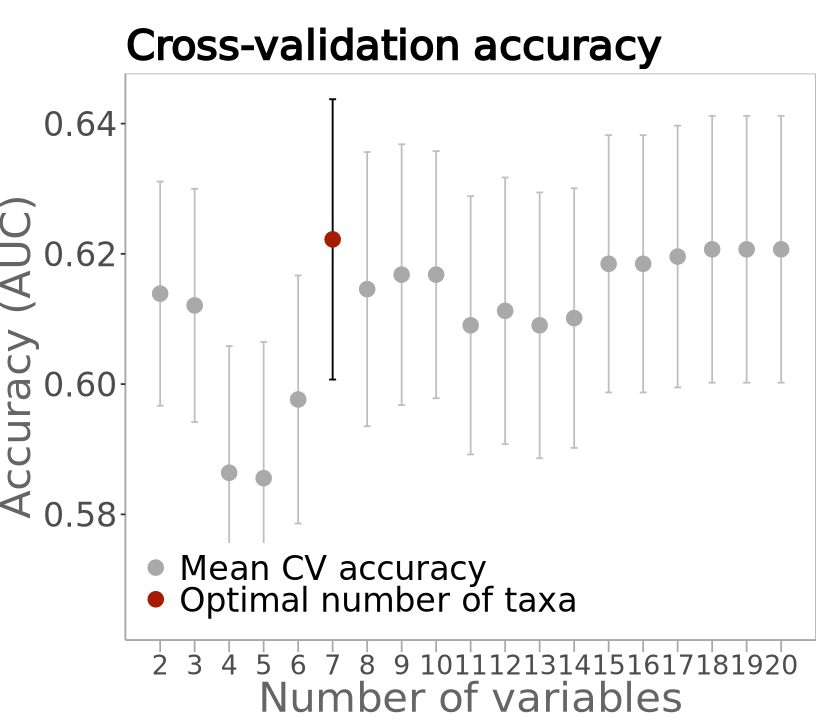

In [16]:
# plot cross validation results
cv_plot <- cv.res$accuracy
cv_plot$layers[[2]] <- NULL
data_optn <- cv_plot$data[cv_plot$data$n == best_nvar(cv.res), ]
data_meanAUC <- cv_plot$data
data_meanAUC$point <- 'Mean CV accuracy'
data_meanAUC[cv_plot$data$n == best_nvar(cv.res), 'point'] <- 'Optimal number of taxa'

# set a figure size
width = 7
height = 6
options(repr.plot.width=width, repr.plot.height=height)
# plot a figure
cv_plot <- cv_plot + 
          geom_errorbar(data = data_optn, aes(ymin=mean-se, ymax=mean+se), width=.2) +
          geom_point(data = data_meanAUC, aes(color=point), size=4, show.legend=TRUE) +
          scale_colour_manual(values = c('darkgrey', '#a51c01'))+
          labs(title='Cross-validation accuracy') +
          theme(axis.text=element_text(size=15),
                        axis.title=element_text(size=25, face="plain"), 
                        plot.title=element_text(size=25, face="bold", hjust=0, vjust=0.5),
                        plot.subtitle=element_blank(),
                        strip.text = element_blank(),
                        axis.text.x.bottom = element_text(size=16, angle=0, face='plain', hjust=0.5),
                        axis.text.y.left = element_text(size=20, angle=0, face='plain', hjust=0.5),
                        axis.text.x = element_blank(),
                        axis.title.x = element_text(color='#656565', face='plain'),
                        axis.title.y = element_text(color='#656565', face='plain'),
                        axis.ticks.x=element_line(color = "darkgrey", linewidth = 0.5),
                        axis.ticks.length.x.bottom=unit(0.5, "lines"),
                        text = element_text(size = 25, face="plain"), 
                        axis.line.y = element_line(color = "darkgrey", linewidth = 0.5), 
                        axis.line.x.bottom = element_line(color = "darkgrey", linewidth = 0.5), 
                        panel.border = element_rect(fill = NA, colour = "grey70", linewidth = rel(1)),
                        panel.spacing.x = unit(2, "lines"),
                        legend.position="inside",
                        legend.position.inside=c(.34, 0.1),
                        legend.title=element_blank(),
                        plot.margin = unit(c(1,1,0,0), "lines")) 
print(cv_plot)

k <- 0.3 # a scaling parameter
ggsave(file=file.path('../../results/figures', 'supplementary_figure6', 'balance.CV.svg'), plot=cv_plot, 
       width=width*k, height=height*k, scaling = k)

In [17]:
# create a balance on baseline deworming data
x <- data.frame(otu_table(ps_baseline_intersected))
y <- data.frame(sample_data(ps_baseline_intersected))[['prior_deworming']]
y[y != 'notTreated'] <- TRUE
y[y == 'notTreated'] <- FALSE
y <- factor(as.numeric(as.logical(y)))

best_nvar(cv.res)
selbal.res <- selbal(x, y, maxV=best_nvar(cv.res), draw = FALSE)

[1] 7

Setting levels: control = 0, case = 1

Setting direction: controls < cases



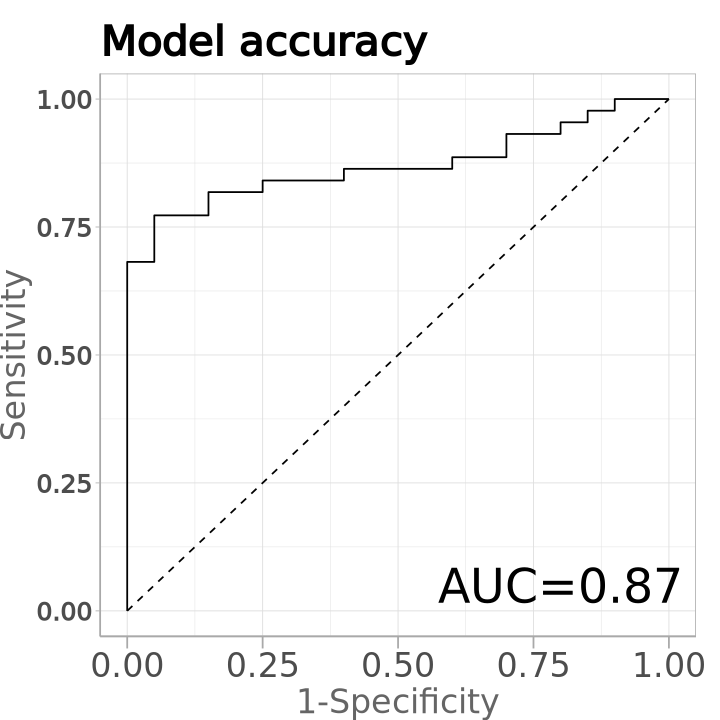

In [20]:
# plot ROC-AUC curve
width = 6
height = 6
options(repr.plot.width=width, repr.plot.height=height)

# compute specificity and sensitivity
roc_score=roc(y, selbal.res$balance.values) #AUC score
# prepare the roc curve data
roc_score_df <- data.frame(Specificity=1-roc_score$specificities, 
                           Sensitivity=roc_score$sensitivities)
roc_score_df <- roc_score_df[order(roc_score_df$Specificity, roc_score_df$Sensitivity), ]
# plot
p <- ggplot(data=roc_score_df, aes(x=Specificity, y=Sensitivity)) +
    geom_line() +
    geom_line(data = data.frame(x=c(0, 1), y=c(0, 1)), aes(x=x, y=y), linetype="dashed") +
    annotate("text", x = 0.8, y = 0.05, label = paste0("AUC=", round(selbal.res$accuracy[6], 2)), 
            size=10) +
    labs(x='1-Specificity', y='Sensitivity', title='Model accuracy') +
    theme_light() +
     theme(axis.text=element_text(size=15),
            axis.title=element_text(size=20, face="plain"), 
            plot.title=element_text(size=25, face="bold"),
            plot.subtitle=element_text(size=22, face="plain"),
            strip.text = element_text(size = 25, hjust=0, color='#656565'), 
            axis.text.x.bottom = element_text(size=20, angle=0, face='plain', hjust=0.5),
            axis.title.x = element_text(color='#656565', face='plain'),
            axis.title.y = element_text(color='#656565', face='plain'),
            axis.ticks.x=element_line(color = "darkgrey", linewidth = 0.5),
            axis.ticks.length.x.bottom=unit(0.5, "lines"),
            text = element_text(size = 25, face="bold"), 
            axis.line.y = element_line(color = "darkgrey", linewidth = 0.5), 
            axis.line.x.bottom = element_line(color = "darkgrey", linewidth = 0.5), 
            panel.border = element_rect(fill = NA, colour = "grey70", linewidth = rel(1)),
            panel.spacing.x = unit(2, "lines"),
            legend.position="bottom", 
            plot.margin = unit(c(1, 1,0, 0), "lines"))

k <- 0.3 # a scaling parameter
# save svg
ggsave(file=file.path('../../results/figures', 'supplementary_figure6', 'model_accuracy.svg'), plot=p, 
       width=width*k, height=height*k, scaling = k)
p

In [18]:
selbal.res$balance.selection

NUMERATOR,DENOMINATOR,ACC,Increase
<chr>,<chr>,<dbl>,<dbl>
Bifidobacterium,Elusimicrobium,0.77386,0.77386
Flavonifractor,-,0.79545,0.02159
-,Escherichia.Shigella,0.82955,0.03409
Anaerostipes,-,0.84205,0.01250
-,Ruminococcaceae_UCG_005,0.85909,0.01705
Ruminococcaceae_UCG_003,-,0.87045,0.01136


In [19]:
# compute how taxa abundances, included in the balance score, change along the score

# select taxa from the balance
taxa <- c(selbal.res$numerator, selbal.res$denominator)
# log transform theitr abundances
balance_correlations <- log(x[, taxa])
# attach the balance score to the table
balance_correlations['y'] <- selbal.res$balance.values[row.names(balance_correlations)]
# find the range of the balance score
balance_range <- seq(min(balance_correlations$y), max(balance_correlations$y), by=0.1)

# for each taxa
taxa_score <- lapply(taxa, function(i){
    subtable <- data.frame(y=balance_correlations$y, 
                           taxa=balance_correlations[[i]])
    subtable <- subtable[subtable$taxa != 0, ]
    # interpolate taxa log values across the balance score
    values <- interp1(subtable$y, 
                      subtable$taxa, 
                      balance_range,
                      'linear')
    # compute the log2fold compared to the mean log abundance of the taxa
    values <- values - mean(values)
    # approximate the change of the log taxa abundance across the balance score with a polynomial of degree 3
    values <- as.vector(lm(values ~ poly(balance_range, 3))$fitted.values)
    # save as a data frame
    df <- data.frame(taxa=values)
    colnames(df) <- i
    return(df)
})
# bind the results from all the taxa of interest
taxa_score <- do.call("cbind", taxa_score)
taxa_score$balance_range <- balance_range
taxa_score <- melt(taxa_score, id.vars=c('balance_range'))
taxa_score$ratio <- 'denominator'
taxa_score[taxa_score$variable %in% selbal.res$numerator, 'ratio'] <- 'numerator'
taxa_score$coef <- taxa_score$variable

Warning message in interp1(subtable$y, subtable$taxa, balance_range, "linear"):
“Points in argument in 'x' unsorted; will be sorted.”
Warning message in interp1(subtable$y, subtable$taxa, balance_range, "linear"):
“Points in argument in 'x' unsorted; will be sorted.”
Warning message in interp1(subtable$y, subtable$taxa, balance_range, "linear"):
“Points in argument in 'x' unsorted; will be sorted.”
Warning message in interp1(subtable$y, subtable$taxa, balance_range, "linear"):
“Points in argument in 'x' unsorted; will be sorted.”
Warning message in interp1(subtable$y, subtable$taxa, balance_range, "linear"):
“Points in argument in 'x' unsorted; will be sorted.”
Warning message in interp1(subtable$y, subtable$taxa, balance_range, "linear"):
“Points in argument in 'x' unsorted; will be sorted.”
Warning message in interp1(subtable$y, subtable$taxa, balance_range, "linear"):
“Points in argument in 'x' unsorted; will be sorted.”


In [21]:
# create a table with taxa names of genera included in the balance
labels <- data.frame(taxa=c(selbal.res$numerator, selbal.res$denominator), 
                     x=c(1:7), 
                     y=c(rep(3, length(selbal.res$numerator)),
                         rep(-5.5, length(selbal.res$denominator))),
                     hjust=c(rep(1, length(selbal.res$numerator)),
                             rep(0, length(selbal.res$denominator))))
labels

taxa,x,y,hjust
<chr>,<int>,<dbl>,<dbl>
Bifidobacterium,1,3.0,1
Flavonifractor,2,3.0,1
Anaerostipes,3,3.0,1
Ruminococcaceae_UCG_003,4,3.0,1
Elusimicrobium,5,-5.5,0
Escherichia.Shigella,6,-5.5,0
Ruminococcaceae_UCG_005,7,-5.5,0


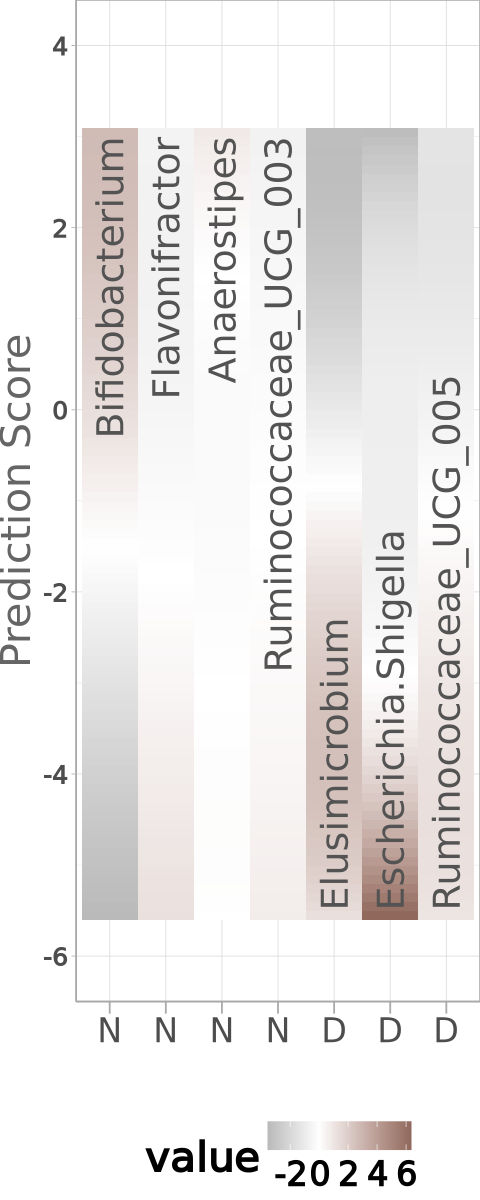

In [22]:
# plot the change of microbial abundance across the score
width = 4
height = 10
options(repr.plot.width=width, repr.plot.height=height)
p_taxa <- ggplot(data = taxa_score) + 
# plot the heatmap
    geom_tile(data = taxa_score, aes(x=variable, y=balance_range, fill = value)) +
# plot the taxa names
    geom_text(data = labels, aes(x=x, y=y, label=taxa, hjust=hjust), 
              vjust=0.5, angle=90, size=8, color="#535353") +
# change the color pallette
    scale_fill_gradient2(
                low="#878787", mid="white", high="#91685c", 
                 midpoint=0)  +
# rename the x ticks
  scale_x_discrete(labels = c(rep('N', length(selbal.res$numerator)),
                              rep('D', length(selbal.res$denominator)))) +
# set the y limits
  ylim(-6, 4)+
# rename x axis
  xlab('')+
# set the title of y axis
  labs(y = "Prediction Score") +
# custom styling options
    theme_light() +
     theme(axis.text=element_text(size=15),
            axis.title=element_text(size=25, face="bold"), 
            plot.title=element_text(size=25, face="bold"),
            plot.subtitle=element_text(size=22, face="plain"),
            strip.text = element_text(size = 25, hjust=0, color='#656565'), 
            axis.text.x.bottom = element_text(size=20, angle=0, face='plain', hjust=0.5),
            axis.title.y = element_text(color='#656565', face='plain'),
            axis.ticks.x=element_line(color = "darkgrey", linewidth = 0.5),
            axis.ticks.length.x.bottom=unit(0.5, "lines"),
            text = element_text(size = 25, face="bold"), 
            axis.line.y = element_line(color = "darkgrey", linewidth = 0.5), 
            axis.line.x.bottom = element_line(color = "darkgrey", linewidth = 0.5), 
            panel.border = element_rect(fill = NA, colour = "grey70", linewidth = rel(1)),
            panel.spacing.x = unit(2, "lines"),
            legend.position="bottom", 
            plot.margin = unit(c(0, 0,0, 0), "lines"))
p_taxa

k <- 0.3
ggsave(file=file.path('../../results/figures', 'figure5', 'balance.taxa_log2fold.svg'), plot=p_taxa, 
       width=width*k, height=height*k, scaling = k)

In [23]:
color = data.frame(sample_data(ps_baseline_intersected))[['prior_deworming_month']]
color[color == 0] = 13
levels(y) <- c('NotTreated', 'Treated')
data_plot <- data.frame(balance = selbal.res$balance.values, y=y, color=color)

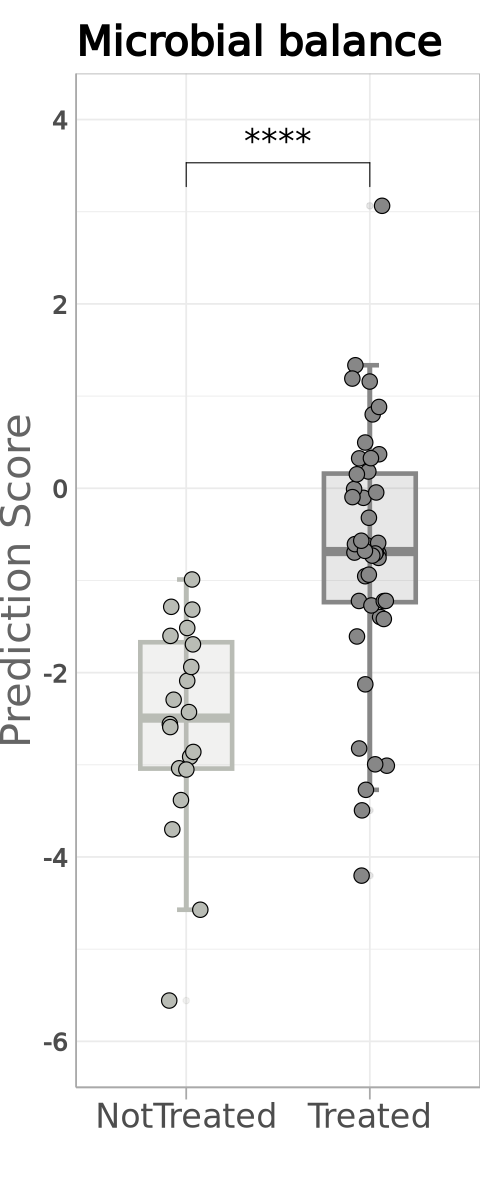

In [24]:
# plot the balance values between 2 groups
width = 4
height = 10
options(repr.plot.width=width, repr.plot.height=height)

comparisons_paired <- list(c("NotTreated", "Treated"))

p_balance_train <- ggplot(data_plot, aes(group=y, x=y, y=balance, color=y, fill=y)) + 
  stat_boxplot(geom = "errorbar", width = 0.1, lwd=1.3) +
  geom_boxplot(alpha=0.2, lwd=1.3, width=0.5)+
  geom_jitter(size=4, width=0.1, shape=21, color='black')+ 
  scale_fill_manual(values = c('#b9bcb5', '#878787')) +
  scale_colour_manual(values = c('#b9bcb5', '#878787'))+
  stat_compare_means(label.y=3.1, method = "wilcox.test",  paired=FALSE, 
                         label = "p.signif", 
                        comparisons = comparisons_paired, 
                        size = 7)  +
  theme_minimal() +
  ylim(-6, 4) +
  theme(axis.text=element_text(size=15),
            axis.title=element_text(size=25, face="bold"), 
            plot.title=element_text(size=25, face="bold"),
            plot.subtitle=element_text(size=22, face="plain"),
            strip.text = element_text(size = 25, hjust=0, color='#656565'), 
            axis.text.x.bottom = element_text(size=20, angle=0, face='plain', hjust=0.5),
            axis.text.x = element_blank(),
            axis.title.y = element_text(color='#656565', face='plain'),
            axis.ticks.x=element_line(color = "darkgrey", linewidth = 0.5),
            axis.ticks.length.x.bottom=unit(0.5, "lines"),
            text = element_text(size = 25, face="bold"), 
            axis.line.y = element_line(color = "darkgrey", linewidth = 0.5), 
            axis.line.x.bottom = element_line(color = "darkgrey", linewidth = 0.5), 
            panel.border = element_rect(fill = NA, colour = "grey70", linewidth = rel(1)),
            panel.spacing.x = unit(2, "lines"),
            legend.position="none", 
            plot.margin = unit(c(1,0,1,0), "lines"))  +
    labs(title = "Microbial balance") + xlab("") + ylab("Prediction Score") 
p_balance_train

In [25]:
STHStatus <- factor(sample_data(ps_baseline_intersected)[['sample_AnySTHs']], levels=c(0, 1))
levels(STHStatus) <- c('STH-', 'STH+')
treatment_and_STHStatus <- paste(data_plot$y, STHStatus, sep='_')
data_plot$treatment_and_STHStatus <- factor(treatment_and_STHStatus)

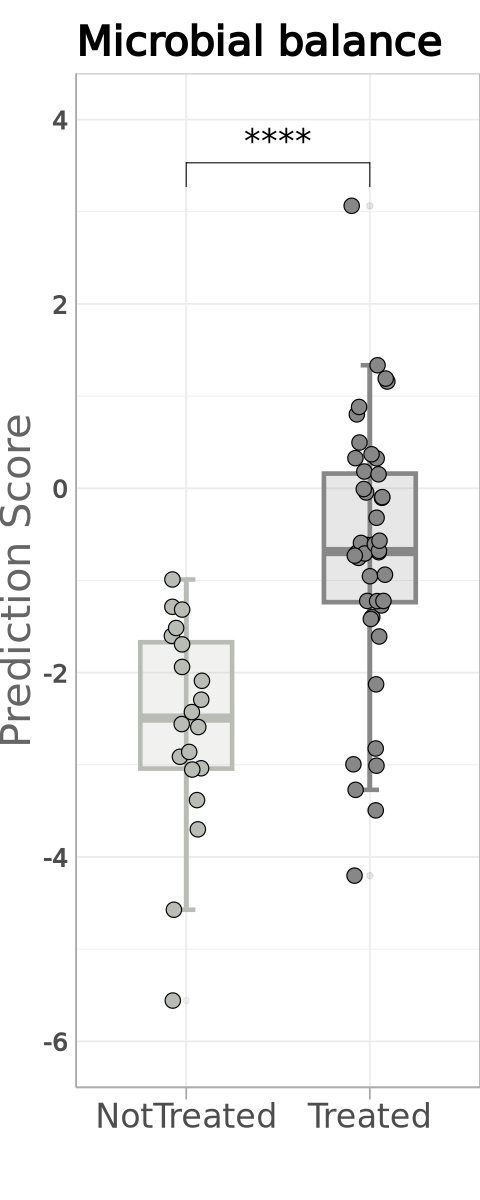

In [26]:
# plot the balance values between 2 groups
width = 4
height = 10
options(repr.plot.width=width, repr.plot.height=height)

comparisons_paired <- list(c("NotTreated_STH-", "NotTreated_STH+"), 
                           c("Treated_STH-", "Treated_STH+"))
 
p_balance_STH <- ggplot(data_plot, aes(group=treatment_and_STHStatus, x=treatment_and_STHStatus, y=balance, 
                                         color=treatment_and_STHStatus, fill=treatment_and_STHStatus)) + 
  stat_boxplot(geom = "errorbar", width = 0.1, lwd=1.3) +
  geom_boxplot(alpha=0.2, lwd=1.3, width=0.5)+
  geom_jitter(size=4, width=0.1, shape=21, color='black')+ 
  scale_fill_manual(values = c('#b9bcb5', '#b9bcb5', '#878787', '#878787')) +
  scale_colour_manual(values = c('#b9bcb5', '#b9bcb5', '#878787', '#878787'))+
  stat_compare_means(label.y=3.1, method = "wilcox.test",  paired=FALSE, 
                         label = "p.signif", 
                        comparisons = comparisons_paired, 
                        size = 7)  +
  theme_minimal() +
  ylim(-6, 4) +
  theme(axis.text=element_text(size=15),
            axis.title=element_text(size=25, face="bold"), 
            plot.title=element_text(size=25, face="bold"),
            plot.subtitle=element_text(size=22, face="plain"),
            strip.text = element_text(size = 25, hjust=0, color='#656565'), 
            axis.text.x.bottom = element_text(size=20, angle=90, face='plain', hjust=0.5),
            axis.text.x = element_blank(),
            axis.title.y = element_text(color='#656565', face='plain'),
            axis.ticks.x=element_line(color = "darkgrey", linewidth = 0.5),
            axis.ticks.length.x.bottom=unit(0.5, "lines"),
            text = element_text(size = 25, face="bold"), 
            axis.line.y = element_line(color = "darkgrey", linewidth = 0.5), 
            axis.line.x.bottom = element_line(color = "darkgrey", linewidth = 0.5), 
            panel.border = element_rect(fill = NA, colour = "grey70", linewidth = rel(1)),
            panel.spacing.x = unit(2, "lines"),
            legend.position="none", 
            plot.margin = unit(c(1,0,1,0), "lines"))  +
    labs(title = "Microbial balance") + xlab("") + ylab("Prediction Score") 
p_balance_train

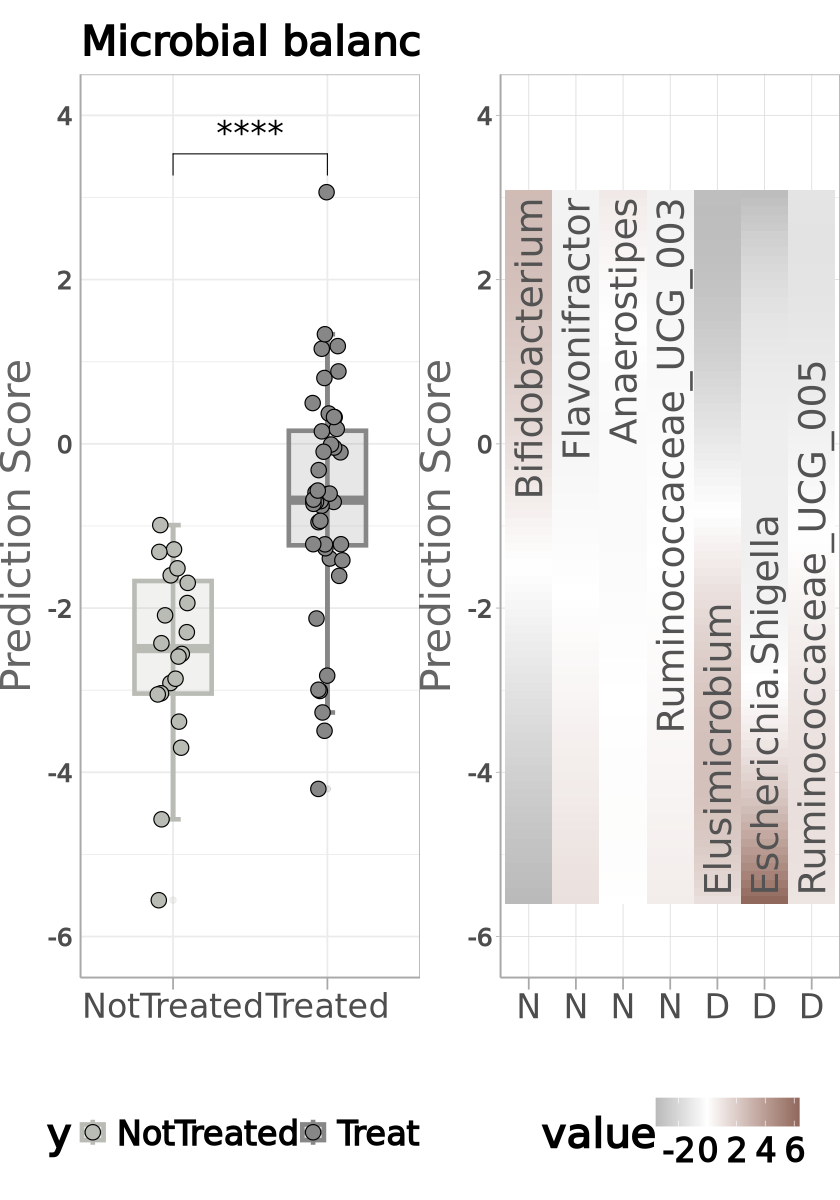

In [27]:
# compbine 2 figures together
width = 7
height = 10
options(repr.plot.width=width, repr.plot.height=height)
p <- ggarrange(p_balance_train, p_taxa,
          ncol = 2, nrow = 1, align = "hv", 
          common.legend = FALSE, legend = "bottom") 
print(p)

k <- 0.3
ggsave(file=file.path('../../results/figures', 'figure5', 'balance.training.svg'), plot=p, 
       width=width*k, height=height*k, scaling = k)

### Predict the balance score on the follow-up data

In [28]:
# predict on post treatment data
numerator_taxa <- selbal.res$numerator
denomenator_taxa <- selbal.res$denominator
x_nonzero <- data.frame(otu_table(ps_followup_intersected))
test_balance <- reconstruct_balance(numerator_taxa, denomenator_taxa, x_nonzero)

In [29]:
# construct a table with the predicted balance from the follow-up samples and 
# balance score computed on the baseline samples
color = data.frame(sample_data(ps_followup_intersected))[['prior_deworming_month']]
color[color == 0] = 13

y <- data.frame(sample_data(ps_followup_intersected))[['prior_deworming']]
y[y != 'notTreated'] <- TRUE
y[y == 'notTreated'] <- FALSE
y <- factor(as.numeric(as.logical(y)))
levels(y)
levels(y) <- c('NotT_followup', 'T_followup')

data_plot_predicted <- data.frame(balance = test_balance, 
                                  y=y, color=color)
STHStatus <- sample_data(ps_followup_intersected)[['sample_AnySTHs']]
STHStatus[STHStatus > 0] <- 1
STHStatus <- factor(STHStatus, levels=c(0, 1))
levels(STHStatus) <- c('STH-', 'STH+')
treatment_and_STHStatus <- paste(data_plot_predicted$y, STHStatus, sep='_')
data_plot_predicted$treatment_and_STHStatus <- factor(treatment_and_STHStatus)

data_plot_predicted <- rbind(data_plot, data_plot_predicted)
data_plot_predicted$y <- factor(data_plot_predicted$y, 
                                levels=c('NotTreated','NotT_followup',
                                         'Treated','T_followup'))
levels(data_plot_predicted$y) <- c('NotT_baseline','NotT_followup',
                                   'T_baseline','T_followup')

analysis_df_ <- analysis_df[!is.na(analysis_df$followup), ]
row.names(analysis_df_) <- analysis_df_$followup
vals_followup <- analysis_df_[row.names(data_plot_predicted), 'host_subject_id']
vals_followup <- as.matrix(data.frame(x=vals_followup, row.names = row.names(data_plot_predicted)))
vals_followup <- data.frame(x=vals_followup[!is.na(vals_followup[, 'x']), ])
row.names(analysis_df) <- analysis_df$baseline
vals_baseline <-analysis_df[row.names(data_plot_predicted), 'host_subject_id']
names(vals_baseline) <- row.names(data_plot_predicted)
vals_baseline <- as.matrix(data.frame(x=vals_baseline, row.names = row.names(data_plot_predicted)))
vals_baseline <- data.frame(x=vals_baseline[!is.na(vals_baseline[,'x']), ])
vals <- rbind(vals_baseline, vals_followup)
data_plot_predicted$host_subject_id <- vals[row.names(data_plot_predicted), 'x']



[1] "0" "1"

In [30]:
# define the style of lines connecting baseline/follow-up pairs of samples
data_plot_predicted$timepoint <- unlist(lapply(as.character(data_plot_predicted$y), 
                                        function(x){strsplit(x, split='_')[[1]][2]} ))
line_type <- dcast(data_plot_predicted, host_subject_id~timepoint, value.var = "balance", id.vars="host_subject_id")
line_type$line_type <- 'increase'
line_type[line_type$baseline > line_type$followup, 'line_type'] <- 'decrease'
row.names(line_type) <- line_type$host_subject_id
data_plot_predicted$line_type <- line_type[data_plot_predicted$host_subject_id, 'line_type']

In [31]:
# compute odds
data_plot_predicted_notreatment <- data_plot_predicted[(data_plot_predicted$y == 'NotT_baseline'), ]
# table(data_plot_predicted_notreatment$line_type)
df <- table(data_plot_predicted_notreatment$line_type)
df[['increase']] / df[['decrease']]

data_plot_predicted_treatment <- data_plot_predicted[(data_plot_predicted$y == 'T_baseline'), ]
# table(data_plot_predicted_notreatment$line_type)
df <- table(data_plot_predicted_treatment$line_type)
df[['increase']] / df[['decrease']]

[1] 2.333333

[1] 0.8333333

In [32]:
# mean scores
data_plot_predicted_notreatment <- data_plot_predicted[(data_plot_predicted$y == 'NotT_baseline'), ]
mean(data_plot_predicted_notreatment$balance)
sd(data_plot_predicted_notreatment$balance)

# mean scores
inds <- (data_plot_predicted$y == 'NotT_followup') | (data_plot_predicted$y == 'T_followup')
data_plot_predicted_followup <- data_plot_predicted[inds, ]
mean(data_plot_predicted_followup$balance)
sd(data_plot_predicted_followup$balance)

[1] -2.568749

[1] 1.142243

[1] -0.919278

[1] 1.755998

In [33]:
# rename xticks
levels(data_plot_predicted$y)
levels(data_plot_predicted$y) <- c('NotTreated', 'NotTfollowup', 'Treated', 'Tfollowup')

[1] "NotT_baseline" "NotT_followup" "T_baseline"    "T_followup"

In [34]:
comparisons_paired <- list(
                    c("NotTreated", "NotTfollowup"),
                    c("Treated", "Tfollowup"))

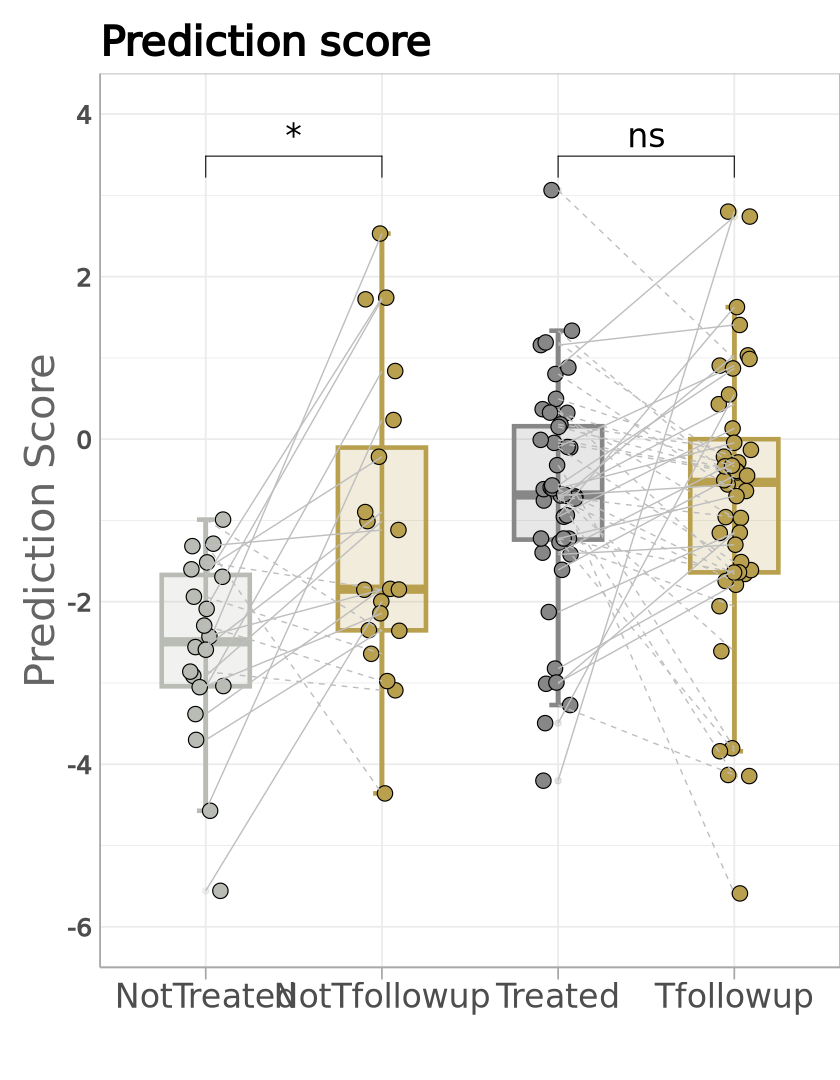

In [35]:
# plot all the computed balances
width = 7
height = 9
options(repr.plot.width=width, repr.plot.height=height)

p_balance <- ggplot(data_plot_predicted, aes(group=y, x=y, y=balance, color=y, fill=y)) + 
  stat_boxplot(geom = "errorbar", width = 0.1, lwd=1.3) +
  geom_boxplot(alpha=0.2, lwd=1.3, width=0.5)+
  geom_jitter(size=4, width=0.1, shape=21, color='black')+ 
  scale_fill_manual(values = c('#b9bcb5', '#b9a04f', '#878787',  '#b9a04f')) +
  scale_colour_manual(values = c('#b9bcb5', '#b9a04f', '#878787', '#b9a04f')) +
  scale_linetype_manual(values = c('dashed', 'solid')) +
  geom_line(aes(x = y, y=balance, group = host_subject_id, linetype=line_type),
                color = "gray", linewidth = 0.4,) +
  stat_compare_means(label.y=3.05, method = "wilcox.test",  paired=TRUE, 
                         label = "p.signif", 
                        comparisons = comparisons_paired, 
                        size = 7) +
  theme_minimal() +
  ylim(-6, 4)+
  theme(axis.text=element_text(size=15),
            axis.title=element_text(size=25, face="bold"), 
            plot.title=element_text(size=25, face="bold"),
            plot.subtitle=element_text(size=22, face="plain"),
            strip.text = element_text(size = 25, hjust=0, color='#656565'), 
            axis.text.x.bottom = element_text(size=20, angle=0, face='plain', hjust=0.5),
            axis.text.x = element_blank(),
            axis.title.y = element_text(color='#656565', face='plain'),
            axis.ticks.x=element_line(color = "darkgrey", linewidth = 0.5),
            axis.ticks.length.x.bottom=unit(0.5, "lines"),
            text = element_text(size = 25, face="bold"), 
            axis.line.y = element_line(color = "darkgrey", linewidth = 0.5), 
            axis.line.x.bottom = element_line(color = "darkgrey", linewidth = 0.5), 
            panel.border = element_rect(fill = NA, colour = "grey70", linewidth = rel(1)),
            panel.spacing.x = unit(2, "lines"),
            legend.position="none", 
            plot.margin = unit(c(1,0,1,1), "lines"))  +
    labs(title = "Prediction score") + xlab("") + ylab("Prediction Score") 
p_balance

k <- 0.3
ggsave(file=file.path('../../results/figures', 'figure5', 'balance.prediction.svg'), plot=p_balance, 
       width=width*k, height=height*k, scaling = k)

### Split scores by STH Status of the particpant at the baseline

In [36]:
# exclude subjects with unknown STH status
data_plot_predicted_selected <- data_plot_predicted[data_plot_predicted$treatment_and_STHStatus != 'T_followup_NA', ]

In [37]:
# list the comparisons for statistical testing
comparisons <- list(c('NotTreated_STH-', 'NotTreated_STH+'),
                    c('Treated_STH-', 'Treated_STH+'), 
                    c('NotT_followup_STH-', 'NotT_followup_STH+'), 
                    c('T_followup_STH-', 'T_followup_STH+'))

Warning message:
“Computation failed in `stat_signif()`.
Caused by error in `if (scales$x$map(comp[1]) == data$group[1] | manual) ...`:
! missing value where TRUE/FALSE needed”
Warning message:
“Computation failed in `stat_signif()`.
Caused by error in `if (scales$x$map(comp[1]) == data$group[1] | manual) ...`:
! missing value where TRUE/FALSE needed”


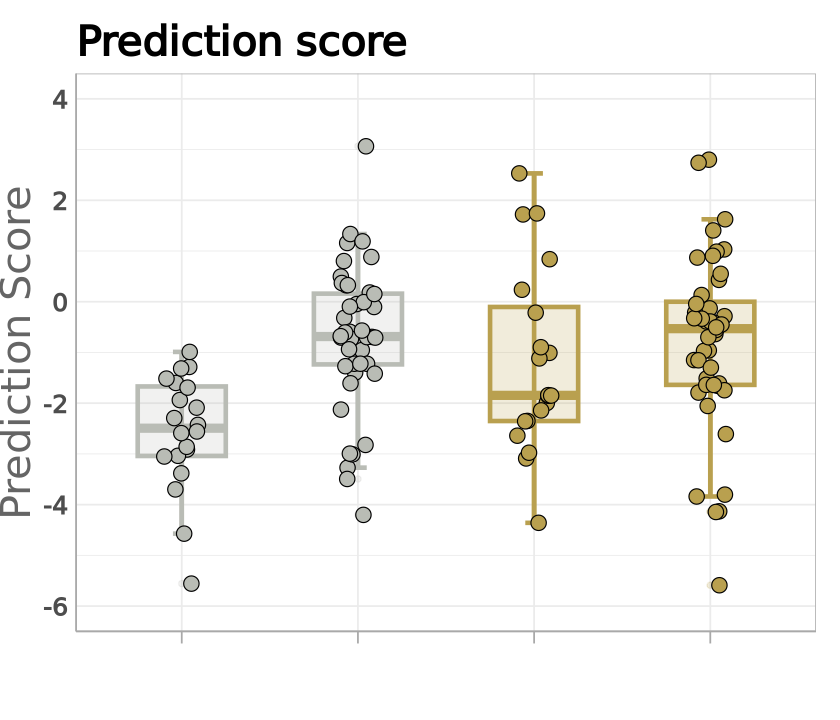

In [38]:
# plot all the computed balances
# width = 7
# height = 9
width = 7
height = 6
options(repr.plot.width=width, repr.plot.height=height)

p_balance <- ggplot(data_plot_predicted_selected, 
                    aes(group=treatment_and_STHStatus, x=treatment_and_STHStatus,
                         y=balance, 
                         color=treatment_and_STHStatus, fill=treatment_and_STHStatus)) + 
  stat_boxplot(geom = "errorbar", width = 0.1, lwd=1.3) +
  geom_boxplot(alpha=0.2, lwd=1.3, width=0.5)+
  geom_jitter(size=4, width=0.1, shape=21, color='black')+ 
  scale_fill_manual(values = c('#b9bcb5', '#b9bcb5', '#b9a04f', '#b9a04f', 
                               '#878787', '#878787',  '#b9a04f', '#b9a04f')) +
  scale_colour_manual(values = c('#b9bcb5', '#b9bcb5', '#b9a04f', '#b9a04f', 
                               '#878787', '#878787',  '#b9a04f', '#b9a04f')) +
  scale_linetype_manual(values = c('dashed', 'solid')) +
  stat_compare_means(label.y=3.05, method = "wilcox.test",  paired=FALSE, 
                         label = "p.signif", 
                        comparisons = comparisons, 
                        size = 7) +
  scale_x_discrete(labels=rep('', 8)) +
  theme_minimal() +
  ylim(-6, 4)+
  theme(axis.text=element_text(size=15),
            axis.title=element_text(size=25, face="bold"), 
            plot.title=element_text(size=25, face="bold"),
            plot.subtitle=element_text(size=22, face="plain"),
            strip.text = element_text(size = 25, hjust=0, color='#656565'), 
            axis.text.x.bottom = element_text(size=20, angle=0, face='plain', hjust=0.5),
            axis.text.x = element_blank(),
            axis.title.y = element_text(color='#656565', face='plain'),
            axis.ticks.x=element_line(color = "darkgrey", linewidth = 0.5),
            axis.ticks.length.x.bottom=unit(0.5, "lines"),
            text = element_text(size = 25, face="bold"), 
            axis.line.y = element_line(color = "darkgrey", linewidth = 0.5), 
            axis.line.x.bottom = element_line(color = "darkgrey", linewidth = 0.5), 
            panel.border = element_rect(fill = NA, colour = "grey70", linewidth = rel(1)),
            panel.spacing.x = unit(2, "lines"),
            legend.position="none", 
            plot.margin = unit(c(1,1, 0, 0), "lines"))  +
    labs(title = "Prediction score") + xlab("") + ylab("Prediction Score") 
p_balance


k <- 0.3 # a scaling parameter
# save svg
ggsave(file=file.path('../../results/figures', 'supplementary_figure6', 
                      'balance.STHStatus.svg'), plot=p_balance, 
       width=width*k, height=height*k, scaling = k)